## This is a Python analysis of RideAustin's daily ride requests, identifying a weekly cycle in requests, and using that cycle to predict weekly growth using an exponential curve fit

Data was made available by CEO Andy Tryba, at https://data.world/andytryba/rideaustin

Ride Austin is a nonprofit, municipal ridesharing service based in Austin, Texas, with a model comparing directly to that of Uber. The data released covers rides requested from June 16 to August 31, just over 11 weeks. It shows a clear cycle weekly, typically with peak ride demand on Saturday. 

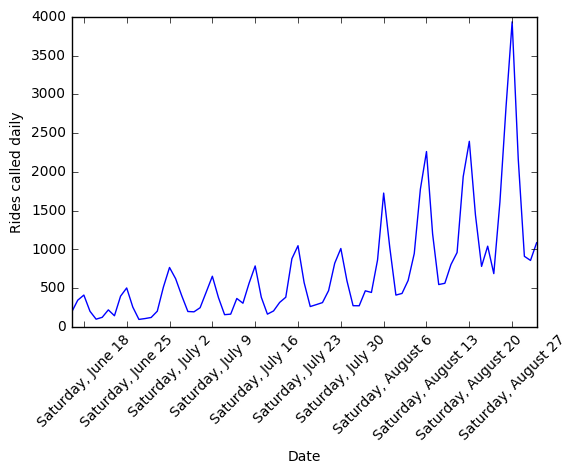

In [119]:
#loading the dataset
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

RideVolume = Series.from_csv('RideVolume.csv', header=0)
RideVolume.plot(xticks=(range(2,78,7)))
plt.xticks(rotation=45) 
plt.ylabel('Rides called daily')
plt.show()
plt.close()

Plainly, the plot shows a regular weekly spike; count and you see 11 spikes, corresponding to the 11+ weeks in the data set. We also see a dramatic growth in this time, a 10-fold expansion from the first to the last Saturday in the series. Though it's less obvious, the less popular days (Monday and Tuesday) also show a roughly 10x expansion across this time. 

Intuitively, the set of points looks much like a exponential growth, with some additional fluctuations in it. To model this as a curve-fit directly from the data points will be difficult, because there is a large difference between the days of the week. So, I'm going to separate the data points available into the different specific days of the week, and perform an exponential growth curve fit on these series, then interpolate the curve of best fit projections into the data.

It would be possible to combine the growth with a circular function to model the weekly interval discretely; because this cycle is asymmetrical this seems difficult, and so I'm modeling each day of the week as a separate market, effectively.

Finally, though we model the growth here as exponential, it will inevitably turn sigmoidal as RideAustin approaches local market saturation. 

This code is adapted in part from Leandro's answer, here:
http://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

### Modeling the days of the week as separate exponential curves

In [145]:
# Separating the CSV into a series for each weekday. It would be easy to 
# define this as a function or class, accepting as parameters a first-
# number offset and the range end as len(RideVolume)
Mondays=RideVolume.iloc[range(4,77,7)]
Tuesdays=RideVolume.iloc[range(5,77,7)]
Wednesdays=RideVolume.iloc[range(6,77,7)]
Thursdays=RideVolume.iloc[range(0,77,7)] 
Fridays=RideVolume.iloc[range(1,77,7)]
Saturdays=RideVolume.iloc[range(2,77,7)]
Sundays=RideVolume.iloc[range(3,77,7)]

print(Mondays)
#print(Tuesdays)
#print(Wednesdays)
#print(Thursdays)
#print(Fridays)
#print(Saturdays)
#print(Sundays)

Date
Monday, June 20      100
Monday, June 27       97
Monday, July 4       402
Monday, July 11      158
Monday, July 18      165
Monday, July 25      263
Monday, August 1     274
Monday, August 8     411
Monday, August 15    547
Monday, August 22    781
Monday, August 29    911
Name: Rides, dtype: int64


In [172]:
#Now we can find a curve which fits to the Saturdays specifically
#Adapted from http://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy
import sympy

# The following creates arrays of data points from the Series objects from earlier. These will be used 
# to perform the curve fit for each set.
SatRides=numpy.array(Saturdays[:], dtype=float)
SunRides=numpy.array(Sundays[:], dtype=float)
MonRides=numpy.array(Mondays[:], dtype=float)
TueRides=numpy.array(Tuesdays[:], dtype=float)
WedRides=numpy.array(Wednesdays[:], dtype=float)
ThuRides=numpy.array(Thursdays[:], dtype=float)
FriRides=numpy.array(Fridays[:], dtype=float)
print('FriRides =',FriRides)
# We can model it using the curve-fit for the data presented as weekly events, which we'll call 'weekly'
# below, but in order to superimpose the function onto the plot we'll need to be able to graph the 
# resulting curve against the days, so we can use both.
weekly=numpy.array(range(1,12,1), dtype=float)

# The following date-specific lists give the location in the original RideVolume 
# series object to which each prediction corresponds. 
MonDateLoc=list(range(4,77,7))
TueDateLoc=list(range(5,77,7))
WedDateLoc=list(range(6,77,7))
ThuDateLoc=list(range(0,77,7))
FriDateLoc=list(range(1,77,7))
SatDateLoc=list(range(2,77,7))
SunDateLoc=list(range(3,77,7))

# Below is an exponential function with unknown coefficient and unknown y-intercept
def func(x, a, b):
    return b + a**x 
# we're going to use scipy's curve_fit to optimize for it
#this may throw a libMKL error unless you're using numpy 11.1.13+
poptSat, pcovSat = curve_fit(func,weekly,SatRides) # x is the 'weekly' array, y is 'SatRides'
print(poptSat) 
poptMon, pcovMon = curve_fit(func,weekly,MonRides)
print(poptMon)

FriRides = [  345.   397.   514.   450.   563.   880.   822.   864.  1777.  1939.
  2839.]
[   2.08648397  840.03616089]
[   1.83447243  215.50045749]


The first list is the optimized parameters for a and b, in the function:
#### Rides called = b + a^week
We can plot this function overlaid on the data, as below:

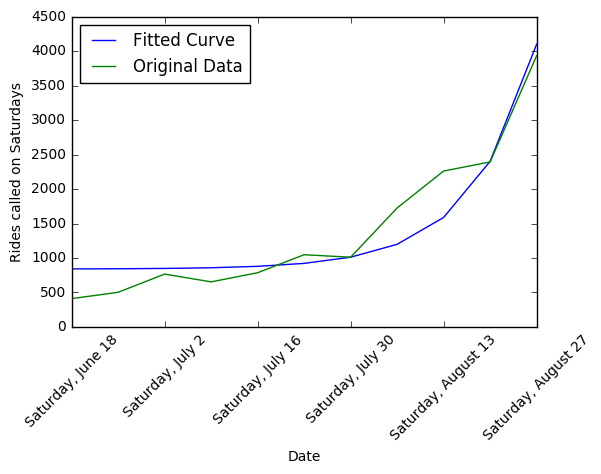

In [151]:
# First overlay the Saturday curve on the original Saturday data.
def SatFunc(x):
    return poptSat[1]+poptSat[0]**x

plt.plot(SatFunc(weekly), label='Fitted Curve')
Saturdays.plot(label="Original Data")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Saturdays')
plt.show()
plt.close()

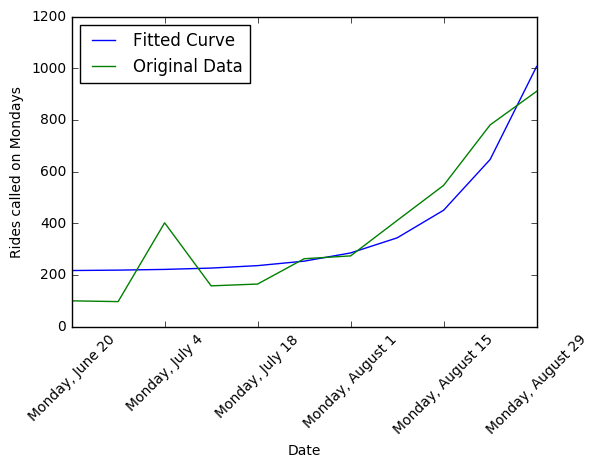

In [157]:
# Then overlay the Monday curve over the Monday original data.
def MonFunc(x):
    return poptMon[1]+poptMon[0]**x

plt.plot(MonFunc(weekly), label='Fitted Curve')
Mondays.plot(label="Original Data")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Mondays')
plt.show()
plt.close()

## Modifying the function to include linear growth
This is pretty satisfying as a fit. We can see that presently the RideAustin Saturday data is a good fit with the exponential growth curve. However, the curve seems like it might be improved with a positive linear growth, so let's modify the function again:

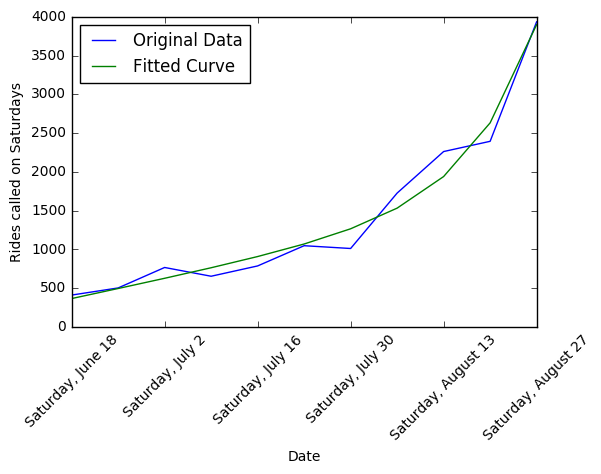

In [177]:
# Below is an exponential function with unknown coefficient and unknown y-intercept
def newFunc(x, a, b, c):
    return a + b*x + c**x 

newpoptSat, newpcovSat = curve_fit(newFunc,weekly,SatRides)
newpoptMon, newpcovMon = curve_fit(newFunc,weekly,MonRides)
def newSatFunc(x):
    return newpoptSat[0]+newpoptSat[1]*x + newpoptSat[2]**x
def newMonFunc(x):
    return newpoptMon[0]+newpoptMon[1]*x + newpoptSat[2]**x

plt.close()
Saturdays.plot(label="Original Data")
plt.plot(newSatFunc(weekly), label='Fitted Curve')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Saturdays')
plt.show()

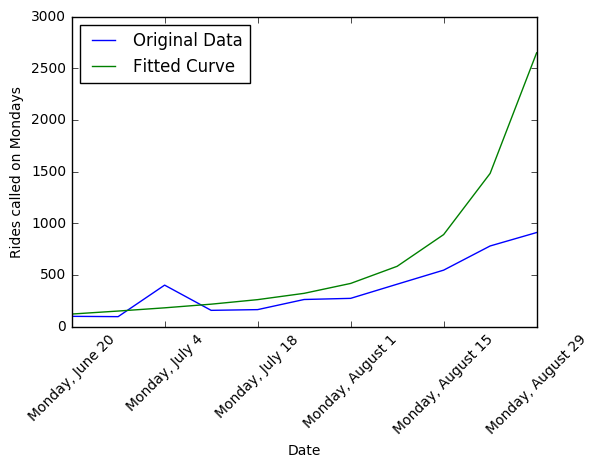

In [179]:
Mondays.plot(label="Original Data")
plt.plot(newMonFunc(weekly), label='Fitted Curve')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called on Mondays')
plt.show()
plt.close()

This is a very good fit for the Saturday data, but a less good fit for the Monday data, seeming to depart from the curve.

### Interleaving weekly projections to make a composite weekly model
Having established that the combined function (exponential growth plus a linear component plus a starting constant) nicely models the Saturdays, we can make a separate model for each of the day series. Then we can interleave the daily projections from each model to make a projected series, and overlay it on the original data to see goodness of fit.

[ 236.35357718  127.66502375    2.017996  ]
[  411.   503.   767.   654.   787.  1048.  1012.  1727.  2263.  2395.
  3937.]


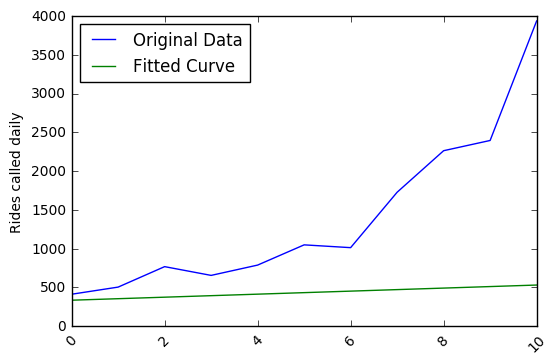

In [21]:
newFuncpopw, newFuncpcovw = curve_fit(newFunction,weekly,SaturdayArray)
print(newFuncpopw)
print(SaturdayArray)

plt.plot(SaturdayArray, label="Original Data")
plt.plot(newFittedFunc(weekly), label='Fitted Curve')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.ylabel('Rides called daily')
plt.show()
plt.close()

This one's plotting kind of funny, so I think it needs work before final delivery.

In [22]:
#print(Saturdays)